# Part 0 - Libraries and Geoinfo file upload

## Available data analysis NYC information

In [2]:
#first import needed libraries
import numpy as np # numpy arrays
import pandas as pd # dataframes and many many other things
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # work with json files
import requests #make requests to urls

import urllib #open urls

! pip install folium
import folium

# installed shapely library from a wheel file - https://www.lfd.uci.edu/~gohlke/pythonlibs/
# instruction to install library into conda using cmd - https://www.geeksforgeeks.org/python-add-packages-to-anaconda-environment/
!pip install shapely
import shapely
import shapely.wkt

from shapely import geometry

import geopy.distance

import ast # for transforming strings to the list/tuple

First we take data related to the New-york city (NYC from now on) Neighborhood tabulation areas (NTAs) <br>
For this I've searched the internet and got to the valuable site, and this directory https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page <br>
https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp/data <br>
here we've found population amounts by NTAs, so we definetely can calculate the population density based on this information. <br>
and income information by NTA 'http://www.city-data.com/nbmaps/neigh-New-York-New-York.html'
'https://statisticalatlas.com/place/New-York/New-York/Household-Income#figure/neighborhood'

In [3]:
url_geoinfo='http://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/nynta/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson'
with urllib.request.urlopen(url_geoinfo) as ref_geoinfo:
    json_geoinfo=json.load(ref_geoinfo)

json_geoinfo.keys()

dict_keys(['type', 'crs', 'features'])

# Part 5 Data modeling

In [4]:
#first we read some data
df_final=pd.read_csv('NYC_stat_aggregated.csv').set_index('NTA Code')
df_final.drop(['Unnamed: 0','Year','Max radius, km','FIPS County Code','Shape type','Poly Count','geometry','Shape centroid','Event'],axis=1,inplace=True)
df_final_clean=df_final.dropna()
print(df_final_clean.shape,df_final.shape)
df_final_clean.head()
# so if we delete all the rows without some of the data, we'll lose 23 NTA's

(172, 18) (195, 18)


Borough                         NTA Name  Population  \
NTA Code                                                        
BX01       Bronx               Claremont-Bathgate       31078   
BX03       Bronx  Eastchester-Edenwald-Baychester       34517   
BX05       Bronx       Bedford Park-Fordham North       54415   
BX06       Bronx                          Belmont       27378   
BX07       Bronx                        Bronxdale       35538   

          Area_normalized, sq km  Population_density    medianinco  medianage  \
NTA Code                                                                        
BX01                    1.511767        20557.397540  35488.638889     32.196   
BX03                    3.699266         9330.770030  40851.083333     32.869   
BX05                    1.378273        39480.562676  38955.694444     33.418   
BX06                    1.245807        21976.112362  32995.722222     31.298   
BX07                    1.395432        25467.377992  37848.583333     32.978   

          popinlabou  labour_coef  Arts & Entertainment  College & University  \
NTA Code                                                                        
BX01           11100     0.361387                     0                     2   
BX03           18067     0.492611                     0                     3   
BX05           23831     0.453138                     0                     1   
BX06            9866     0.382655                     1                     6   
BX07           16507     0.489415                     2                     1   

          Food  Nightlife Spot  Outdoors & Recreation  \
NTA Code                                                
BX01        14               1                      3   
BX03         3               2                      0   
BX05        19               2                      1   
BX06        21              11                      3   
BX07        44               2                      3   

          Professional & Other Places  Residence  Shop & Service  \
NTA Code                                                           
BX01                               39          0              32   
BX03                                4          0               5   
BX05                               19         13              30   
BX06                               33          9              27   
BX07                               25          6              83   

          Travel & Transport  
NTA Code                      
BX01                       7  
BX03                       3  
BX05                       7  
BX06                      16  
BX07                      11

In [5]:
!pip install sklearn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y_data=df_final_clean[['Food']]
x_data=df_final_clean.drop(['Borough','NTA Name','Food'],axis=1)
#x_data=df_final_clean.drop(['NTA Code','Borough','NTA Name','Food'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

[[-0.019]]
R^2 for the test data is -0.028889413606880025


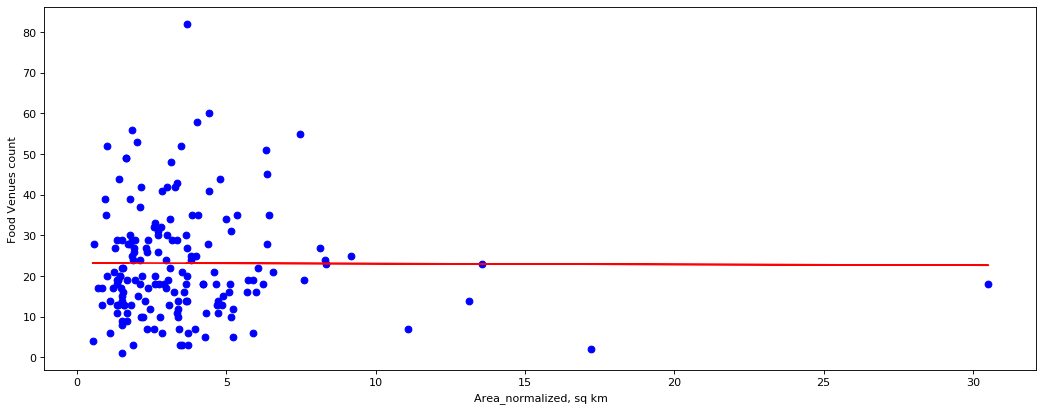

In [6]:
lr=linear_model.LinearRegression()

x_train_select=x_train[['Area_normalized, sq km']]
x_test_select=x_test[['Area_normalized, sq km']]
lr.fit(x_train_select,y_train)
np.set_printoptions(precision=4,formatter={"float_kind": lambda x: "%g" % x})
print(np.around(lr.coef_,decimals=4))

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_train_select, lr.coef_[0][0]*x_train_select + lr.intercept_[0], '-r')
plt.scatter(df_final_clean['Area_normalized, sq km'], df_final_clean['Food'], color='blue')
plt.xlabel("Area_normalized, sq km")
plt.ylabel("Food Venues count")
print('R^2 for the test data is {}'.format(lr.score(x_test_select, y_test)))
plt.show()
#as you can see, NTA area size doesn't show any significant effect on the Food venues count, and R^2 error is somewhere on the floor

[[0.0001]]
R^2 for the test data is 0.03736822714645871


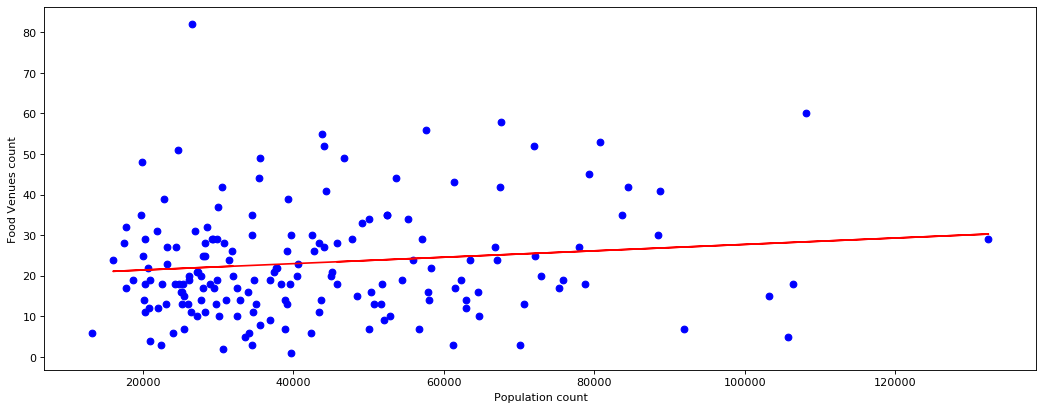

In [7]:
x_train_select=x_train[['Population']]
x_test_select=x_test[['Population']]
lr.fit(x_train_select,y_train)
np.set_printoptions(precision=4,formatter={"float_kind": lambda x: "%g" % x})
print(np.around(lr.coef_,decimals=4))

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_train_select, lr.coef_[0][0]*x_train_select + lr.intercept_[0], '-r')
plt.scatter(df_final_clean['Population'], df_final_clean['Food'], color='blue')
plt.xlabel("Population count")
plt.ylabel("Food Venues count")
print('R^2 for the test data is {}'.format(lr.score(x_test_select, y_test)))
plt.show()
#as you can see, NTA population doesn't show any significant effect on the Food venues count, and R^2 error is also very low

[[0.0002]]
R^2 for the test data is 0.07905248632358297


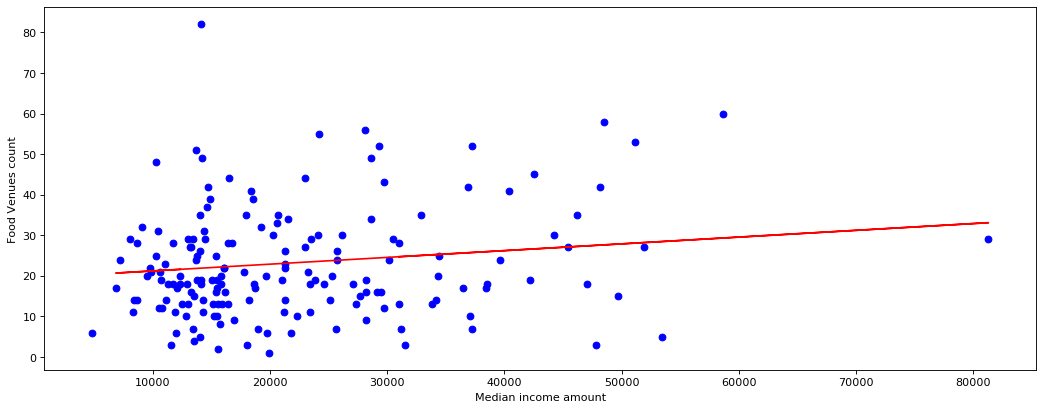

In [8]:
x_train_select=x_train[['popinlabou']]
x_test_select=x_test[['popinlabou']]
lr.fit(x_train_select,y_train)
np.set_printoptions(precision=4,formatter={"float_kind": lambda x: "%g" % x})
print(np.around(lr.coef_,decimals=4))

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_train_select, lr.coef_[0][0]*x_train_select + lr.intercept_[0], '-r')
plt.scatter(df_final_clean['popinlabou'], df_final_clean['Food'], color='blue')
plt.xlabel("Median income amount")
plt.ylabel("Food Venues count")
print('R^2 for the test data is {}'.format(lr.score(x_test_select, y_test)))
plt.show()
# well, for population that is working, we have a 0.08 R squared, which I will include in our model creation

[[0.6065]]
R^2 for the test data is 0.4712213321880685


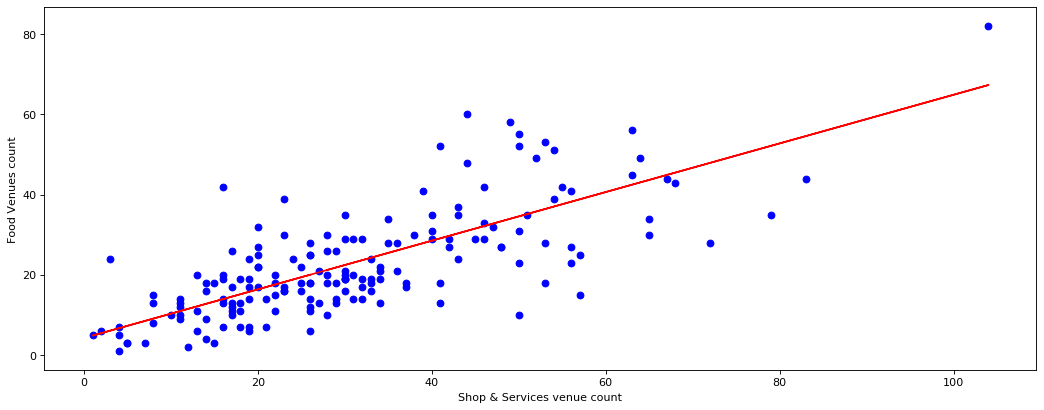

In [9]:
x_train_select=x_train[['Shop & Service']]
x_test_select=x_test[['Shop & Service']]
lr.fit(x_train_select,y_train)
np.set_printoptions(precision=4,formatter={"float_kind": lambda x: "%g" % x})
print(np.around(lr.coef_,decimals=4))

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_train_select, lr.coef_[0][0]*x_train_select + lr.intercept_[0], '-r')
plt.scatter(df_final_clean['Shop & Service'], df_final_clean['Food'], color='blue')
plt.xlabel("Shop & Services venue count")
plt.ylabel("Food Venues count")
print('R^2 for the test data is {}'.format(lr.score(x_test_select, y_test)))
plt.show()
# well, for population that is working, we have a almost 0.5 R squared

### Now let's try linear models with x as 'Nightlife Spot' and 'Shop & Service'

In [23]:
from sklearn.metrics import mean_squared_error

y_data=df_final[['Food']]
x_data=df_final[['Nightlife Spot']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

lr.fit(x_train,y_train)
print("The test R squared is equal to", lr.score(x_test,y_test), 'mean squared error is equal to',mean_squared_error(y_test,lr.predict(x_test)))
pd.DataFrame(lr.coef_,columns=x_train.columns)

The test R squared is equal to 0.15880010193315353 mean squared error is equal to 152.41590894703884


Nightlife Spot
0         1.68135

In [24]:
y_data=df_final[['Food']]
x_data=df_final[['Shop & Service']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

lr.fit(x_train,y_train)
print("The test R squared is equal to", lr.score(x_test,y_test), 'mean squared error is equal to',mean_squared_error(y_test,lr.predict(x_test)))
pd.DataFrame(lr.coef_,columns=x_train.columns)

The test R squared is equal to 0.36263496687902375 mean squared error is equal to 115.48333645479528


Shop & Service
0        0.544124

### Let's create a multilinear Regression

In [25]:
y_data=df_final[['Food']]
x_data=df_final[['popinlabou','Arts & Entertainment','College & University','Nightlife Spot','Outdoors & Recreation','Professional & Other Places','Residence','Shop & Service','Travel & Transport']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

lr.fit(x_train,y_train)
print("The test R squared is equal to", lr.score(x_test,y_test), 'mean squared error is equal to',mean_squared_error(y_test,lr.predict(x_test)))
pd.DataFrame(lr.coef_,columns=x_train.columns)

The test R squared is equal to 0.41540803891915595 mean squared error is equal to 105.92145257748038


popinlabou  Arts & Entertainment  College & University  Nightlife Spot  \
0     0.00016             -0.224002              0.134391         0.94292   

   Outdoors & Recreation  Professional & Other Places  Residence  \
0               0.104772                     0.192709  -0.039128   

   Shop & Service  Travel & Transport  
0        0.415281            0.024598

### Now let's try Ridge regression

In [77]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train)
x_test_pr=pr.fit_transform(x_test)

RidgeModel=Ridge(alpha=200000000) # experimenting with various degree and alpha values this looks like the optimal solution
RidgeModel.fit(x_train_pr, y_train)
print("The train R squared is equal to", RidgeModel.score(x_train_pr,y_train), 'mean squared error is equal to',mean_squared_error(y_train,RidgeModel.predict(x_train_pr)))
print("The test R squared is equal to", RidgeModel.score(x_test_pr,y_test), 'mean squared error is equal to',mean_squared_error(y_test,RidgeModel.predict(x_test_pr)))

The train R squared is equal to 0.6072533092972754 mean squared error is equal to 75.18160304949576
The test R squared is equal to 0.44154983365603595 mean squared error is equal to 101.18485499171622


### And as the last model, let's try to do K-fold for the multilinear Regression

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# since we've deleted all the unessesary data, we can restore 20 deleted NTA's with NaN values
#x_data=df_final_clean.drop(['NTA Code','Borough','NTA Name','Food'],axis=1)
#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)
#lr.fit(x_train,y_train)
#print('R^2 for the test data is {}'.format(lr.score(x_test, y_test)))
#pd.DataFrame(np.around(lr.coef_,decimals=4),columns=x_train.columns)
Rcross = cross_val_score(lr, x_data, y_data, cv=4)
yhat=cross_val_predict(lr,x_data, y_data,cv=4)
print("The mean of the folds are", Rcross.mean(), "and the mean squared error is" , mean_squared_error(y_data,yhat))

The mean of the folds are 0.5162571686631838 and the mean squared error is 84.98332217125713


## And the K-fold model shown the best result! let's apply it to the whole dataset to determine which NTA is the most undersaturated

In [11]:
def minus_func(row):
    return row['Food venues estimate']-row['Food']

df_compare=df_final[['NTA Name','Borough','Food']]
df_compare.loc[:,'Food venues estimate']=cross_val_predict(lr,x_data, y_data,cv=4)
df_compare.loc[:,'Food Venue count diff']=df_compare.apply(minus_func,axis=1)
df_compare.sort_values('Food Venue count diff',ascending=False).head(10)

C:\Users\Sanj1\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sanj1\Anaconda3\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


NTA Name        Borough  Food  \
NTA Code                                                                  
QN72                                      Steinway         Queens    14   
BK58                                     Flatlands       Brooklyn    10   
SI08                 Grymes Hill-Clifton-Fox Hills  Staten Island     3   
BK88                                  Borough Park       Brooklyn    18   
BK90                             East Williamsburg       Brooklyn     6   
MN20                          Murray Hill-Kips Bay      Manhattan    13   
QN68      Queensbridge-Ravenswood-Long Island City         Queens     5   
QN61                                       Jamaica         Queens    16   
QN50                              Elmhurst-Maspeth         Queens    15   
MN21                                      Gramercy      Manhattan    17   

          Food venues estimate  Food Venue count diff  
NTA Code                                               
QN72                 39.481201              25.481201  
BK58                 34.198500              24.198500  
SI08                 25.418050              22.418050  
BK88                 39.899113              21.899113  
BK90                 25.871071              19.871071  
MN20                 31.553394              18.553394  
QN68                 22.293135              17.293135  
QN61                 32.888958              16.888958  
QN50                 31.033503              16.033503  
MN21                 32.725388              15.725388

# So this cross-validated multiple linear regression concludes our task of seing the most undersaturated restaurant Neighborhood tabulation areas in New-york city
### As a bonus, let's build a map using the results that we have

In [12]:
world_map = folium.Map(location=[40.7128,-74.0060], zoom_start=12)
#please be aware that location=[latitude, longitude] is encoded in folium, however GEOjson files have [longitude,latitude] written down
df_compare.reset_index(inplace=True)
folium.Choropleth(
     name='Food Venues prediction differences',
     geo_data=json_geoinfo,
     data=df_compare,
     columns=['NTA Code', 'Food Venue count diff'],
     key_on='feature.properties.NTACode',
     fill_color='YlOrRd', 
     fill_opacity=0.7, 
     line_opacity=0.2,
     legend_name='Difference between predicted and actual Food Venue Count'
).add_to(world_map)

world_map